In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
from scipy.interpolate import UnivariateSpline
import scipy
%matplotlib inline
from tqdm.auto import tqdm
import quaternion as quat

In [8]:
def chi2(y1,y2,sy):
    '''
    Compute the Chi2 value.
    '''
    return(np.sum(np.square(x-y)/sy**2))

def ML15(q,earth,a,b,c,sun=[1,0,0]):
    '''
    Compute the M&L lightcurve model.
    '''
    sun = quat.from_vector_part(sun) # turn the sun point to a quaternion
    earth = quat.from_vector_part(earth)
    
    sun   = q *  sun  * q.inverse() # compute the sun vectors from rotations
    earth = q * earth * q.inverse() # compute the earth vectors from rotations
    
    # get the vector parts of both vector sets
    sun   = quat.as_vector_part(sun) 
    earth = quat.as_vector_part(earth)
    
    C = np.array([1/a**2,1/b**2,1/c**2]) # compute the scaling matrix C
    
    # compute the scaling constants Tsun, Tearth
    Tsun   = np.sqrt(np.einsum('ij,j,ij->i',sun,C,sun))
    Tearth = np.sqrt(np.einsum('ij,j,ij->i',earth,C,earth))
    
    # compute cos(alpha)
    cosa = np.einsum('ij,j,ij->i',sun,C,earth)/(Tearth*Tsun) 
    cosa = np.minimum(cosa,1)
    cosa = np.maximum(cosa,-1)
    
    # compute alpha
    aprime = np.arccos(cosa)
    aprime[np.isclose(aprime,0)]=0
    
    # compute scaling constant T
    T=np.sqrt(np.abs(Tsun**2 + Tearth**2 + 2*Tsun*Tearth*cosa))
    
    # compute cos(lambda) and sin(lambda)
    cosl=np.nan_to_num((Tsun+Tearth*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((Tearth*np.sin(aprime))/T,posinf=0,neginf=0)

    # compute the lambda values
    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    # compute the tan and cotan
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    # compute the M&L brightness
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Tsun*Tearth/T)[L!=0]
    L[L==0] = 1e-15
    
    return(np.abs(L))

def ellipse_grad(r,a,b,c):
    '''
    Compute the gradient of the ellipse.
    '''
    x,y,z = r
    return((x**2/a**4+y**2/b**4+z**2/c**4)**(-1/2)*np.array([x/a**2,y/b**2,z/c**2]))

def matquatmul(A,q):
    '''
    Compute the matrix multiplication of a 4x4 matrix A and 
    the 4-vector representation of a quaternion q. 
    '''
    assert(A.shape==(4,4))
    return(quat.from_float_array(np.dot(A,quat.as_float_array(q))))

def quatdot(q1,q2):
    '''
    Compute the "quaternion dot product", which is the dot product if the quaternions 
    are in 4-vector form. 
    '''
    return(np.quaternion(np.dot(quat.as_float_array(q1),
                  quat.as_float_array(q2)),0,0,0))

def compMoI(a,b,c,M):
    '''
    Compute the diagonal components of the moment of inertia matrix.
    '''
    return(M/5*np.array([b**2+c**2,a**2+c**2,a**2+b**2]))

def substellarpt(q,a,b,c,sun=[1,0,0]):
    '''
    Compute the sub-stellar point. 
    '''
    C = np.diag([0,a,b,c])
    
    sun = q.inverse()*np.quaternion(0,*sun)*q

    norm = np.sqrt(np.norm(matquatmul(C,sun)))
    
    rss = matquatmul(C**2,sun)/norm
    
    if np.abs(matquatmul(np.diag([0,1/a**2,1/b**2,1/c**2]),(q.inverse()*rss*q)))<0:
        rss *= -1
    
    return(rss)
    
def comptorque(qp,a,b,c,M=1,A=1):
    '''
    Compute the torque based on the substellar outgassing.
    '''
    rss = substellarpt(qp,a,b,c).vec
    return(M*A*np.quaternion(0,*np.cross(rss,-1*ellipse_grad(rss,a,b,c))))

def compwdot(q,w,a,b,c,M,A):
    '''
    Compute the time derivative of the angular velocity, using the torque.
    
    Used in the CG/RK method.
    '''
    
    Ja,Jb,Jc = compMoI(a,b,c,M)
    
    J = np.diag([1,Ja,Jb,Jc])
    Jinv = np.linalg.inv(J)
    
    Jw = matquatmul(J,w)
    
    term1 = matquatmul(-Jinv,w*Jw)-quatdot(w,Jw)
    term2 = matquatmul(Jinv,comptorque(q,a,b,c,M,A))
    
    return(term1+term2)

def getspacing(xarr,dx=1):
    '''
    Compute a new discrete array with a maximum spacing of dx, 
    and which is a superset of xarr.
    '''
    spacing = np.diff(xarr)
    
    inds = np.where(spacing>=dx)[0]
    
    for i in inds[::-1]:
        xmin,xmax = xarr[i],xarr[i+1]
        npts = int((xmax-xmin)//dx)
        xlist = list(np.linspace(xmin,xmax,npts+2)[1:-1])
        
        xarr[(i+1):(i+1)] = xlist
        
    return(xarr)

def initqp(qw,betai):
    '''
    Compute the initial quaternion position from the initial rotation axis and angle.
    
    Assumes that qw is a pure quaternion with the rotation axis as a vector part.
    '''
    u = qw.vec/np.abs(qw)
    qp = quat.from_rotation_vector(u*betai)
    return(qp)

def initqw(theta,phi,P):
    '''
    Compute the initial pure-quaternion for the rotation axis w. 
    
    theta and phi are the polar and azimuthal angles, and P is the rotation period. 
    '''
    
    qw = np.quaternion(0,np.cos(theta),np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi))
    qw *= 2*np.pi/P
    return(qw)

def compute_model(qp,qw,time,a,b,c,M,A):
    '''
    Compute the attitude over time using the torque model.
    '''
    att = [qp]
    angvec = [qw]
    
    f = lambda t,q,w: 0.5*w*q
    
    for dt in np.diff(time):
        qp,qw = PCDM(qp,qw,compwdot,dt,a,b,c,M,A)
        
        att.append(qp)
        angvec.append(qw)
        
    return(np.array(att),np.array(angvec))

def PCDM(qp0,qw0,compwdot,dt,a,b,c,M,A):
    '''
    Computes the variables at the relevant time step, as given by Iraz´abal et a. 
    '''
    
    #tau0 = comptorque(qp,a,b,c,M,A)
    wdot0 = compwdot(qp0,qw0,a,b,c,M,A)
    
    qw1 = qw0 + dt/4*wdot0
    qw2 = qw0 + dt/2*wdot0
    
    qw1i = qp0*qw1*qp0.inverse()
    qp2 = np.exp(dt/4*qw1i)*qp0
    
    qw2i = qp2*qw2*qp2.inverse()
    qpn = np.exp(dt/2*qw2i)*qp0
    
    wdot2 = compwdot(qpn,qw2,a,b,c,M,A)
    qwn = qw0 + wdot2*dt
    
    return(qpn,qwn)
    

In [9]:
def comptorque(qp,a,b,c,M=1,A=1):
    '''
    Compute the torque based on the substellar outgassing.
    '''
    return(np.quaternion(0,0,0,0))

def testlocation(q,att):
    test = att*q*att.conj()
    return(quat.as_vector_part(test))

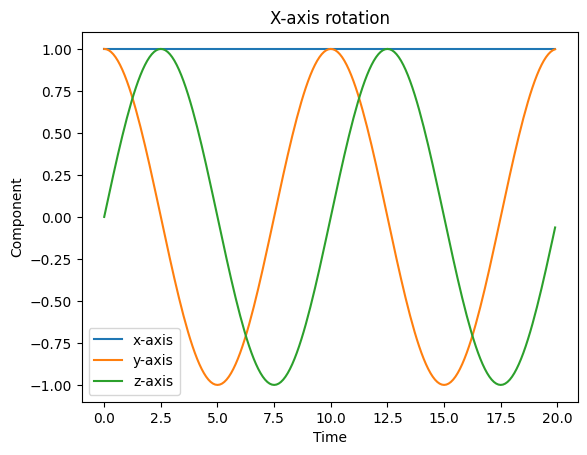

CPU times: user 570 ms, sys: 838 ms, total: 1.41 s
Wall time: 391 ms


In [4]:
%%time

P = 10 #period

time = np.arange(0,20,.1)

qp = np.quaternion(1,0,0,0) # initial quaternion attitude. null conditions
qw = np.quaternion(0,2*np.pi/P,0,0) # initial angular velocity quaternion (NOT dqp/dt!)

att, angvec = compute_model(qp,qw,time,6,4,1,1,1)

testx = testlocation(np.quaternion(0,1,0,0),att)[:,0]
testy = testlocation(np.quaternion(0,0,1,0),att)[:,1]
testz = testlocation(np.quaternion(0,0,1,0),att)[:,2] #this is a rotation of the y-vector, to show the phase offset

plt.plot(time,testx,label='x-axis')
plt.plot(time,testy,label='y-axis')
plt.plot(time,testz,label='z-axis')
plt.title("X-axis rotation")
plt.xlabel("Time")
plt.ylabel("Component")
plt.legend()
plt.show()

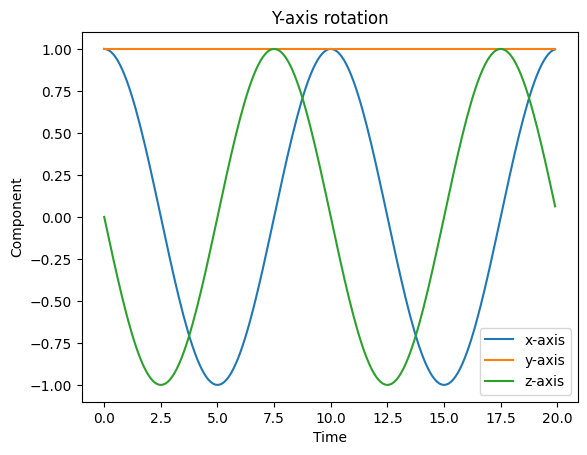

CPU times: user 723 ms, sys: 795 ms, total: 1.52 s
Wall time: 428 ms


In [5]:
%%time

P = 10 #period

time = np.arange(0,20,.1)

qp = np.quaternion(1,0,0,0) # initial quaternion attitude. null conditions
qw = np.quaternion(0,0,2*np.pi/P,0) # initial angular velocity quaternion (NOT dqp/dt!)

att, angvec = compute_model(qp,qw,time,6,4,1,1,1)

testx = testlocation(np.quaternion(0,1,0,0),att)[:,0]
testy = testlocation(np.quaternion(0,0,1,0),att)[:,1]
testz = testlocation(np.quaternion(0,1,0,0),att)[:,2] #this is a rotation of the x-vector, to show the phase offset

plt.plot(time,testx,label='x-axis')
plt.plot(time,testy,label='y-axis')
plt.plot(time,testz,label='z-axis')
plt.title("Y-axis rotation")
plt.xlabel("Time")
plt.ylabel("Component")
plt.legend()
plt.show()

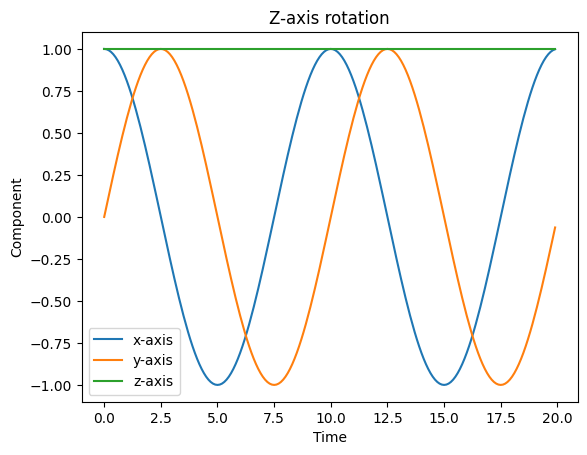

CPU times: user 597 ms, sys: 544 ms, total: 1.14 s
Wall time: 354 ms


In [6]:
%%time

P = 10 #period

time = np.arange(0,20,.1)

qp = np.quaternion(1,0,0,0) # initial quaternion attitude. null conditions
qw = np.quaternion(0,0,0,2*np.pi/P) # initial angular velocity quaternion (NOT dqp/dt!)

att, angvec = compute_model(qp,qw,time,6,4,1,1,1)

testx = testlocation(np.quaternion(0,1,0,0),att)[:,0]
testy = testlocation(np.quaternion(0,1,0,0),att)[:,1] #this is a rotation of the x-vector, to show the phase offset
testz = testlocation(np.quaternion(0,0,0,1),att)[:,2] 

plt.plot(time,testx,label='x-axis')
plt.plot(time,testy,label='y-axis')
plt.plot(time,testz,label='z-axis')
plt.title("Z-axis rotation")
plt.xlabel("Time")
plt.ylabel("Component")
plt.legend()
plt.show()

In [7]:
def comptorque(qp,a,b,c,M=1,A=1):
    '''
    Compute the torque based on the substellar outgassing.
    '''
    rss = substellarpt(qp,a,b,c).vec
    return(M*A*np.quaternion(0,*np.cross(rss,-1*ellipse_grad(rss,a,b,c))))

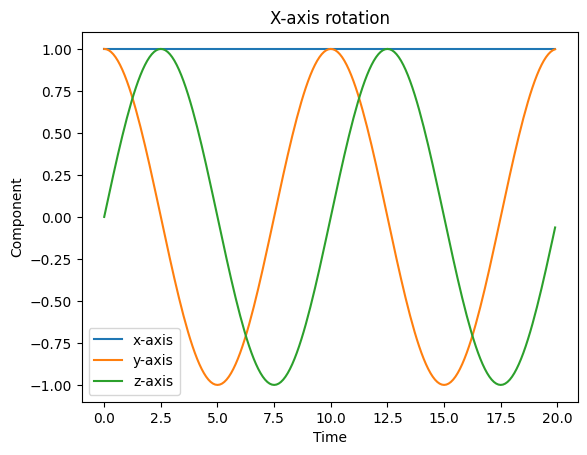

CPU times: user 597 ms, sys: 802 ms, total: 1.4 s
Wall time: 407 ms


In [8]:
%%time

P = 10 #period

time = np.arange(0,20,.1)

qp = np.quaternion(1,0,0,0) # initial quaternion attitude. null conditions
qw = np.quaternion(0,2*np.pi/P,0,0) # initial angular velocity quaternion (NOT dqp/dt!)

att, angvec = compute_model(qp,qw,time,6,4,1,1,1)

testx = testlocation(np.quaternion(0,1,0,0),att)[:,0]
testy = testlocation(np.quaternion(0,0,1,0),att)[:,1]
testz = testlocation(np.quaternion(0,0,1,0),att)[:,2] #this is a rotation of the y-vector, to show the phase offset

plt.plot(time,testx,label='x-axis')
plt.plot(time,testy,label='y-axis')
plt.plot(time,testz,label='z-axis')
plt.title("X-axis rotation")
plt.xlabel("Time")
plt.ylabel("Component")
plt.legend()
plt.show()

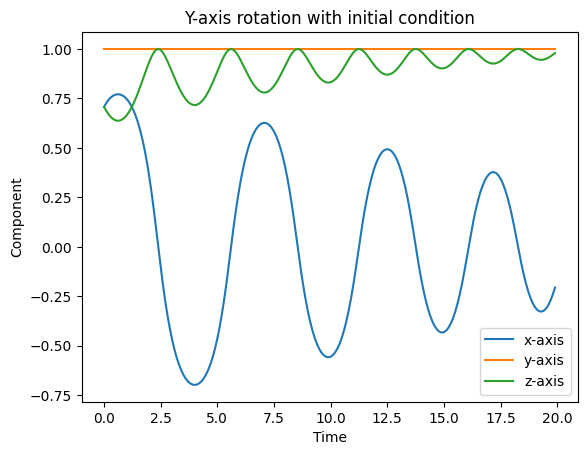

CPU times: user 587 ms, sys: 812 ms, total: 1.4 s
Wall time: 380 ms


In [9]:
%%time

P = 20 #period

time = np.arange(0,20,.1)

qp = np.quaternion(np.cos(np.pi/8),0,-np.sin(np.pi/8),0) # initial quaternion attitude. pi/4 in the clockwise direction
qw = np.quaternion(0,0,2*np.pi/P,0) # initial angular velocity quaternion (NOT dqp/dt!). negative for towards the sun

att, angvec = compute_model(qp,qw,time,6,4,1,1,1)

testx = testlocation(np.quaternion(0,1,0,0),att)[:,0]
testy = testlocation(np.quaternion(0,0,1,0),att)[:,1]
testz = testlocation(np.quaternion(0,1,0,0),att)[:,2] #this is a rotation of the x-vector, to show the phase offset

plt.plot(time,testx,label='x-axis')
plt.plot(time,testy,label='y-axis')
plt.plot(time,testz,label='z-axis')
plt.title("Y-axis rotation with initial condition")
plt.xlabel("Time")
plt.ylabel("Component")
plt.legend()
plt.show()

In [10]:
def comptorque(qp,a,b,c,M=1,A=1):
    '''
    Compute the torque based on the substellar outgassing.
    '''
    theta = qp.angle()-np.pi/2
    return(np.quaternion(0,0,0,-A*theta))

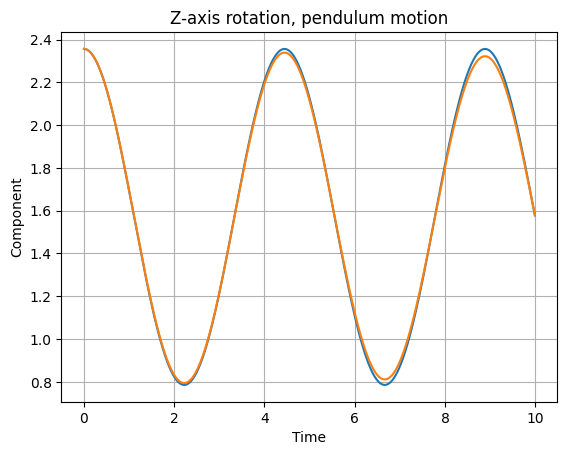

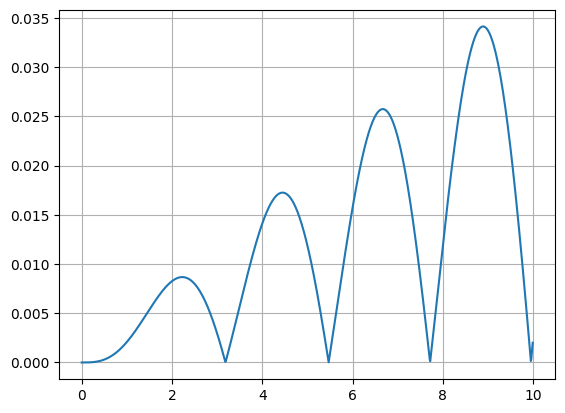

CPU times: user 639 ms, sys: 1.26 s, total: 1.9 s
Wall time: 474 ms


In [11]:
%%time

P = 20 #period

time = np.arange(0,10,.01)

beta = np.pi*(1/2+1/4)

k=2

qp = np.quaternion(np.cos(beta/2),0,0,np.sin(beta/2))
qw = np.quaternion(0,0,0,0) # initial angular velocity quaternion (NOT dqp/dt!). negative for towards the sun

att, angvec = compute_model(qp,qw,time,2,1,1,1,k)

testx = [q.angle() for q in att]

truex = (beta-np.pi/2)*np.cos(np.sqrt(k)*time)+np.pi/2

#plt.plot(time,np.abs(testx)-np.abs(truex))
plt.plot(time,truex,label='y-axis')
plt.plot(time,testx,label='x-axis')
#plt.plot(time,testz,label='z-axis')
plt.title("Z-axis rotation, pendulum motion")
plt.xlabel("Time")
plt.ylabel("Component")
#plt.legend()
plt.grid()
plt.show()

plt.plot(time,np.abs(testx-truex))
plt.grid()
plt.show()

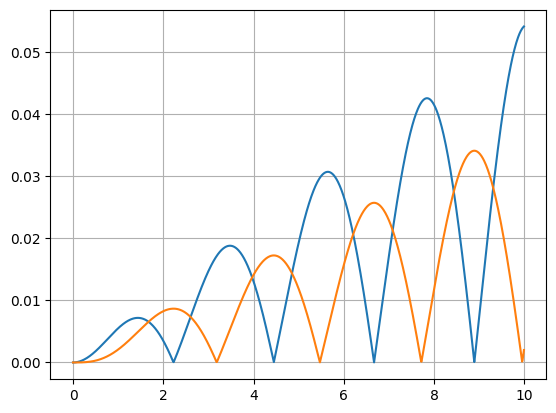

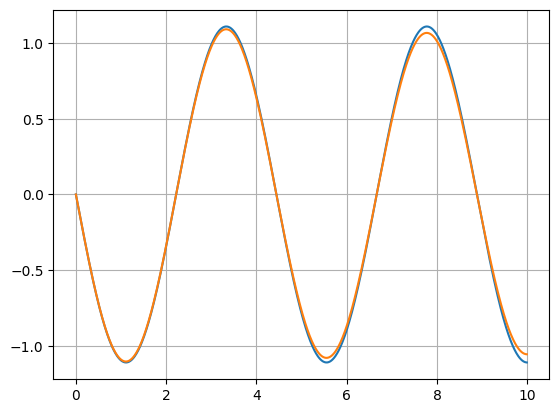

In [34]:
truew = -(beta-np.pi/2)*np.sqrt(k)*np.sin(np.sqrt(k)*time)

testw = quat.as_float_array(angvec)[:,3]

plt.plot(time,np.abs(testw-truew))
plt.plot(time,np.abs(testx-truex))
plt.grid()
plt.show()

plt.plot(time,truew)
plt.plot(time,testw)
plt.grid()
plt.show()


In [15]:
print(att[:])

[quaternion(0.38268343236509, 0, 0, 0.923879532511287)
 quaternion(0.382719712734409, 0, 0, 0.923864503855674)
 quaternion(0.382828539417441, 0, 0, 0.923819413850731) ...
 quaternion(0.853990081511868, 0, 0, 0.520289285570398)
 quaternion(0.853958249693321, 0, 0, 0.520341529940407)
 quaternion(0.853901630817103, 0, 0, 0.520434438606722)]


In [16]:
print(angvec[:])

[quaternion(0, 0, 0, 0) quaternion(0, 0, 0, -0.0157063924716222)
 quaternion(0, 0, 0, -0.0314080730255028) ...
 quaternion(0, 0, 0, 0.00747141555772881)
 quaternion(0, 0, 0, 0.0169973085135313)
 quaternion(0, 0, 0, 0.0265188494183354)]
